In [1]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from inference.commons import get_model, get_tensor
from albumentations import RandomCrop
from pyquaternion import Quaternion

In [2]:
base_dir = '/mnt/tb_storage/uprojects/posenet/dataset/'
csv_path = os.path.join(base_dir, 'info.csv')
img_dir = os.path.join(base_dir, 'images')

In [26]:
df = pd.read_csv(csv_path)
df[:10]

,Unnamed: 0,Unnamed: 0.1,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,IMU_LAX,IMU_LAY,IMU_LAZ,IMU_AVX,IMU_AVY,IMU_AVZ,ImageFile,DepthFile,SegFile
0,0,0,1542098918672,1.628652,-1.342870,-0.038781,1.000000,-0.0,0.0,0.000000,-0.012323,0.012355,-9.793530,0.000031,0.000238,0.000235,img_0_0_1542098919031247900.png,img_0_3_1542098919034924900.png,img_0_5_1542098919037481300.png
1,1,1,1542098927672,0.539220,-0.753961,-0.038781,0.219876,-0.0,0.0,0.975528,-0.004269,-0.007061,-9.796641,-0.000113,0.000299,0.000157,img_0_0_1542098928056216200.png,img_0_3_1542098928058906700.png,img_0_5_1542098928061151600.png
2,2,2,1542099006672,1.811826,-1.783541,-0.038781,0.845706,-0.0,0.0,0.533649,0.007127,-0.006138,-9.802512,0.000018,0.000242,-2.073797,img_0_0_1542099007064132600.png,img_0_3_1542099007066469000.png,img_0_5_1542099007068223000.png
3,3,3,1542099035673,1.735275,0.055900,-0.038781,0.988930,-0.0,0.0,0.148384,4.352539,3.855151,-9.808618,-0.000499,-0.000436,-1.609914,img_0_0_1542099036029939100.png,img_0_3_1542099036032202400.png,img_0_5_1542099036034012000.png
4,4,4,1542099047673,-1.467342,-0.783857,-0.038781,0.127870,0.0,-0.0,-0.991791,0.001481,-0.007924,-9.816813,0.000579,0.000273,-0.000102,img_0_0_1542099048061266300.png,img_0_3_1542099048063828800.png,img_0_5_1542099048066488000.png
5,5,5,1542099065673,0.451957,0.408581,-0.038781,0.998721,-0.0,0.0,0.050560,0.012654,-0.006117,-9.813839,-0.000084,0.000020,0.247340,img_0_0_1542099066033315900.png,img_0_3_1542099066035907800.png,img_0_5_1542099066037893600.png
6,6,6,1542099084673,1.410518,-1.137061,-0.038781,0.367928,-0.0,0.0,0.929854,-0.006066,-0.009834,-9.826376,-0.000310,-0.000789,-0.049669,img_0_0_1542099085056313300.png,img_0_3_1542099085059098500.png,img_0_5_1542099085061113500.png
7,7,7,1542099104673,1.409426,-2.626755,-0.038781,0.463715,0.0,-0.0,-0.885984,0.010483,-0.007756,-9.815042,0.000146,-0.000411,0.110015,img_0_0_1542099105098529700.png,img_0_3_1542099105100997700.png,img_0_5_1542099105102974200.png
8,8,8,1542099105673,1.231574,-2.860746,-0.038781,0.446471,0.0,-0.0,-0.894798,0.005457,0.012056,-9.802399,0.000382,-0.000553,0.012068,img_0_0_1542099106052372000.png,img_0_3_1542099106054721200.png,img_0_5_1542099106056662900.png
9,9,9,1542099110673,0.955471,-3.581909,-0.038781,0.998886,0.0,-0.0,-0.047189,0.000672,-0.008851,-9.808173,0.000131,0.000796,-0.238255,img_0_0_1542099111060389300.png,img_0_3_1542099111065377600.png,img_0_5_1542099111067531500.png


##Check extremal positions

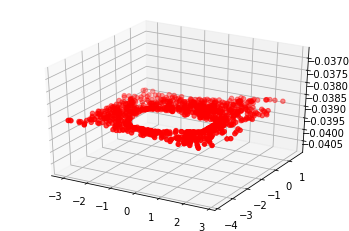

In [4]:
X = np.array(df['POS_X'])
Y = np.array(df['POS_Y'])
Z = np.array(df['POS_Z'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c='r', marker='o')

##Predict and visualize vectors sample image from dataset

In [5]:
model = get_model('inference/weights/weights.pth')

In [37]:
random_sample = df.sample().iloc[0]
img = cv2.imread(os.path.join(img_dir, random_sample['ImageFile']))
rc = RandomCrop(299, 299)
batch = np.array([rc(image=img)['image'] for i in range(20)])
batch = torch.from_numpy(np.moveaxis(batch.astype(np.float32) / 255., -1, 1))
output = model(batch)
pred_pos = np.mean(output[0].cpu().data.numpy().copy(), axis=0)
pred_qtn = np.mean(output[1].cpu().data.numpy().copy(), axis=0)
pred_pos, pred_qtn

(array([-1.3037132 , -0.2570004 , -0.02554983], dtype=float32),
 array([ 0.22077696, -0.00172705,  0.00127927,  0.90099764], dtype=float32))

In [38]:
gt_data = random_sample[3:10].get_values().astype(np.float32)
gt_pos, gt_qtn = gt_data[:3], gt_data[-4:]
gt_pos, gt_qtn

(array([-1.302403, -0.182427, -0.038781], dtype=float32),
 array([ 0.17864 , -0.      ,  0.      ,  0.983914], dtype=float32))

In [39]:
def get_result_vector(pos: [], qtn: []):
    quat = Quaternion(qtn)
    return quat.rotate(pos)

In [40]:
gt_v = get_result_vector(gt_pos, gt_qtn)
pred_v = get_result_vector(pred_pos, pred_qtn)

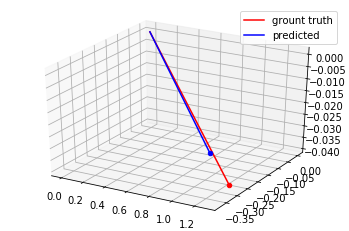

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(np.array([0,gt_v[0]]), np.array([0,gt_v[1]]), np.array([0,gt_v[2]]), color='r', label='grount truth')
ax.scatter(gt_v[0], gt_v[1], gt_v[2], c='r', marker='o')
ax.plot(np.array([0,pred_v[0]]), np.array([0,pred_v[1]]), np.array([0,pred_v[2]]), color='b', label='predicted')
ax.scatter(pred_v[0], pred_v[1], pred_v[2], c='b', marker='o')
ax.legend()